In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, pickle
import sys
from skimage import io
import os

sys.path.append("../../")


%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Dataset

In [14]:
data_dir = '/data/natalia/intern20/PaperData/cellpose/' ## This should be the file where the .npz files are

pd_file = pd.read_csv(data_dir+'files.csv')
pd_file['input_dir'] = data_dir
pd_file.to_csv(data_dir + 'files.csv')

print(pd_file) 
print()

#get number of instances per segmentation class
for i in range(len(pd_file)):
    group = pd_file['group'][i]
    print(pd_file['input_dir'][i] + pd_file['input_file'][i])
    npz_read = np.load(pd_file['input_dir'][i] + pd_file['input_file'][i])
    image = npz_read['image']        
    label = npz_read['label']
    
    #initialize lists
    if i == 0:
        if len(label.shape)>2:
            nclasses = label.shape[-1]
        else:
            nclasses = 1
        nlabels_class_train_list = [0 for i in range(nclasses)]
        nlabels_class_test_list = [0 for i in range(nclasses)]
    
    if len(label.shape)>2:
        for ix in range(label.shape[-1]):
            if group == 'train':
                nlabels_class_train_list[ix] += np.unique(label[...,ix]).shape[0] - 1
            else:
                nlabels_class_test_list[ix] += np.unique(label[...,ix]).shape[0] - 1
    else: #only one class
        if group == 'train':
            nlabels_class_train_list[0] += np.unique(label).shape[0] - 1
        else:
            nlabels_class_test_list[0] += np.unique(label).shape[0] - 1
        

print()
print('----')
print('total train instances per class (',nclasses, 'classes)')
print(nlabels_class_train_list)
print('total test instances per class (',nclasses, 'classes)')
print(nlabels_class_test_list)

    Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1                         prefix  \
0            0             0               0  000_img_cellpose_train_folder   
1            1             1               1  001_img_cellpose_train_folder   
2            2             2               2  002_img_cellpose_train_folder   
3            3             3               3  003_img_cellpose_train_folder   
4            4             4               4  004_img_cellpose_train_folder   
..         ...           ...             ...                            ...   
69          69            69              69   004_img_cellpose_test_folder   
70          70            70              70   006_img_cellpose_test_folder   
71          71            71              71   007_img_cellpose_test_folder   
72          72            72              72   008_img_cellpose_test_folder   
73          73            73              73   010_img_cellpose_test_folder   

                                     input_dir  \
0

## Scribble Generation

In [15]:
nlabels_budget = 300 ## number of label's scribbles

In [16]:
from skimage import morphology

def erosion_labels(label,radius_pointer=1): 
    #needed to generate scribbles from boundaries since in many cases 
    #there is no background between different instances
    selem = morphology.disk(radius_pointer)
    mask = np.zeros_like(label)
    for vlabel in np.unique(label):
        if vlabel != 0:
            mask_label = np.zeros_like(label)
            mask_label[label == vlabel] = 1
            aux = morphology.dilation(mask_label, selem=selem)
            if np.unique(aux*label).shape[0] > 2: #overlaps with other label
                erode_label = morphology.erosion(mask_label, selem=selem)
                mask[erode_label>0] = vlabel
            else:
                mask[mask_label>0] = vlabel
    ## Image Corners
    mask[:,0:radius_pointer] = label[:,0:radius_pointer]
    mask[:,-radius_pointer-1:] = label[:,-radius_pointer-1:]
    mask[0:radius_pointer,:] = label[0:radius_pointer,:]
    mask[-radius_pointer-1:,:] = label[-radius_pointer-1:,:]
    return mask

/data/natalia/intern20/PaperData/cellpose/000_img_cellpose_train_folder.npz


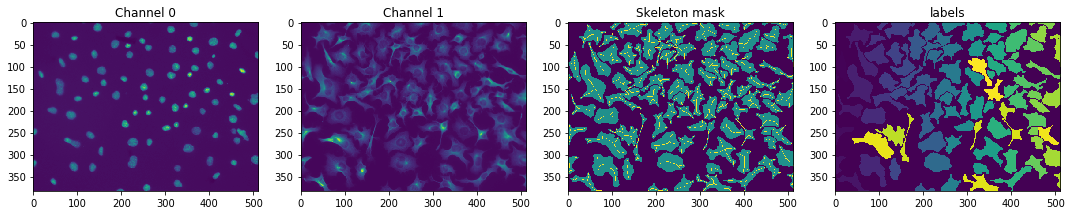

/data/natalia/intern20/PaperData/cellpose/003_img_cellpose_train_folder.npz


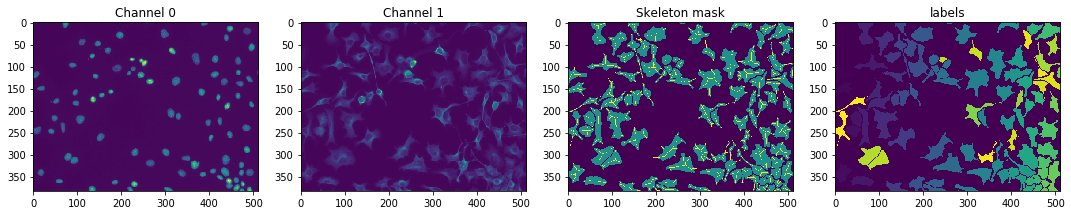

/data/natalia/intern20/PaperData/cellpose/006_img_cellpose_train_folder.npz


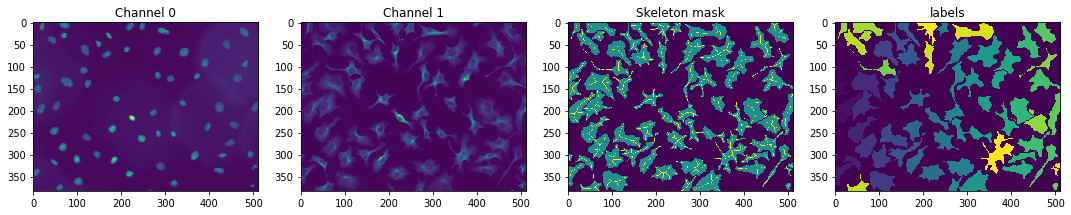

/data/natalia/intern20/PaperData/cellpose/009_img_cellpose_train_folder.npz


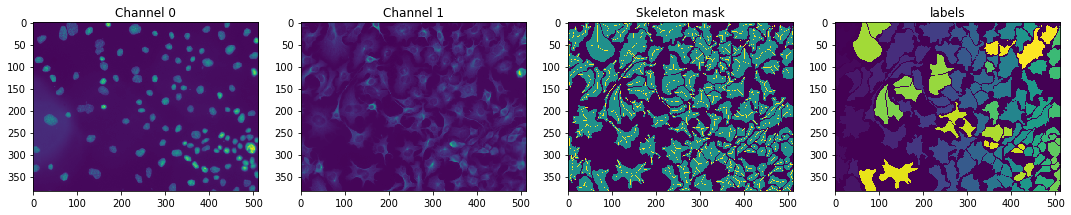

/data/natalia/intern20/PaperData/cellpose/019_img_cellpose_train_folder.npz


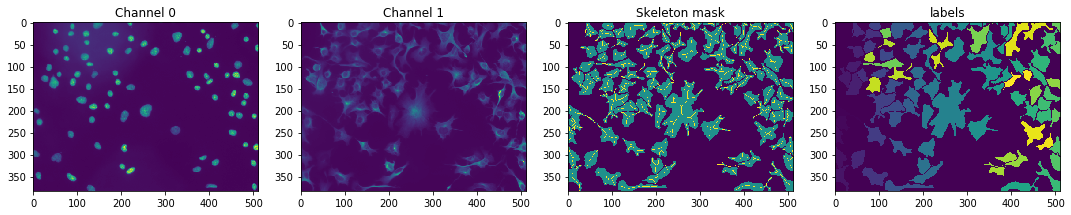

/data/natalia/intern20/PaperData/cellpose/035_img_cellpose_train_folder.npz


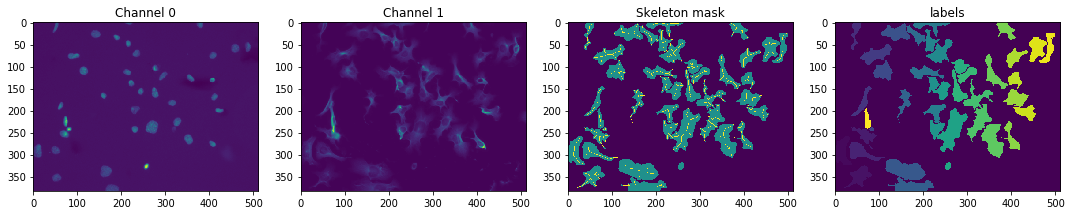

/data/natalia/intern20/PaperData/cellpose/039_img_cellpose_train_folder.npz


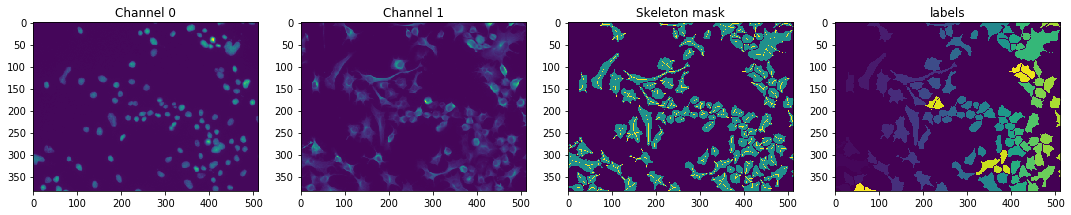

/data/natalia/intern20/PaperData/cellpose/096_img_cellpose_train_folder.npz


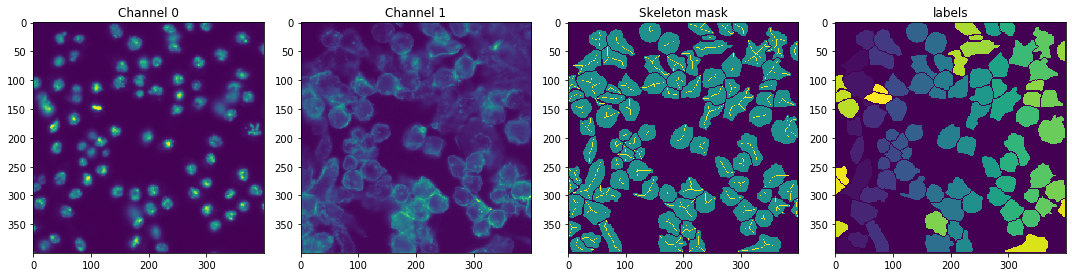

/data/natalia/intern20/PaperData/cellpose/099_img_cellpose_train_folder.npz


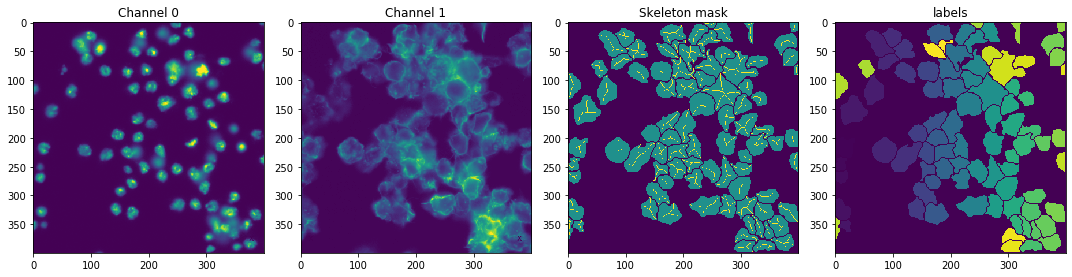

/data/natalia/intern20/PaperData/cellpose/102_img_cellpose_train_folder.npz


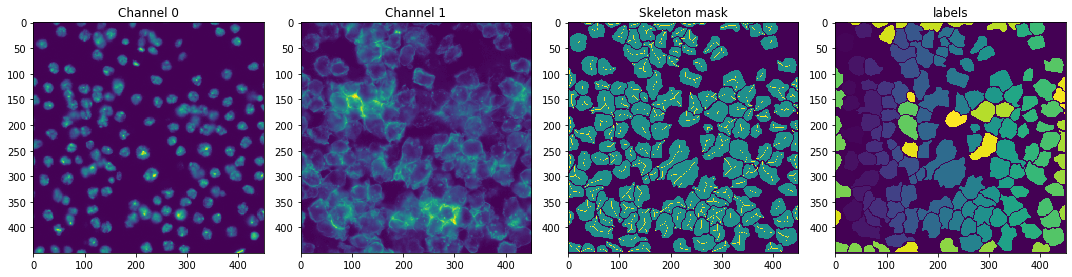

In [17]:
from skimage import morphology
from dataprocessing.labelgeneration import get_scribbles

#load train segmentations in a list
X_train_list = []

Y_gt_train_ch0_list = []

files_train_list_aux = []

nlabels_total0 = 0

for i in range(len(pd_file)):
    group = pd_file['group'][i]
    if group == 'train':

        print(pd_file['input_dir'][i] + pd_file['input_file'][i])
        npz_read = np.load(pd_file['input_dir'][i] + pd_file['input_file'][i])
        image = npz_read['image']        
        label0 = npz_read['label']
        label0 = erosion_labels(label0,radius_pointer=1)
        nlabels_total0 += np.unique(label0).shape[0]-1
        
        X_train_list.append(image)
        Y_gt_train_ch0_list.append(label0)
        
        files_train_list_aux.append([pd_file['input_dir'][i],
                                 pd_file['input_file'][i],
                                 pd_file['prefix'][i],])

        #nuclei mask
        nuclei0 = np.zeros_like(label0)
        nuclei0[label0>0] = 1

        plt.figure(figsize=(15,5))
        
        plt.subplot(1,4,1)
        plt.title('Channel 0')
        plt.imshow(image[...,0])
        
        plt.subplot(1,4,2)
        plt.title('Channel 1')
        plt.imshow(image[...,1])
        
        plt.subplot(1,4,3)
        skeleton = morphology.skeletonize(nuclei0)
        plt.title('Skeleton mask')
        plt.imshow(nuclei0+skeleton)
        
        plt.subplot(1,4,4)
        skeleton = morphology.skeletonize(nuclei0)
        plt.title('labels')
        plt.imshow(label0)
        
        plt.tight_layout()
        plt.show()

In [18]:
np.random.seed(43)

### whole object scribbles (ch0) (the only available in this dataset)
Y_out_ch0_list, nscribbles_ch0_list, nlabels_ch0_list = get_scribbles(Y_gt_train_ch0_list,
                                                                     nlabels_budget,
                                                                     fov_box=(32,32),
                                                                     radius_pointer=0,
                                                                     disk_scribble = True,
                                                                     sample_back = True)

total labels per sample (image):  [ 90.  94.  65. 121.  90.  40. 111.  88.  86. 154.]
sample_i,nbudget,nscribbles
5 300 30
2 270 30
8 239 29
7 210 30
0 180 30
4 150 30
1 119 29
6 90 30
3 60 30
9 30 30


0 ['/data/natalia/intern20/PaperData/cellpose/', '000_img_cellpose_train_folder.npz', '000_img_cellpose_train_folder']
000_img_cellpose_train_folder_1task1class_10images_scribble_n300.npz
93920 183 224
31 183 20 224
check unique values scribbles : [0. 1.]
/data/natalia/intern20/PaperData/cellpose/000_img_cellpose_train_folder_1task1class_10images_scribble_n300.npz


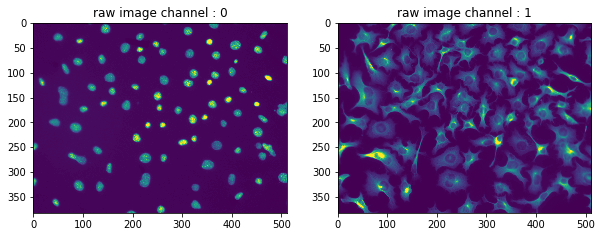

 task 0 ; classes : [0]
check sum of scribbles on same class (=1 or 0) : [0. 1.]


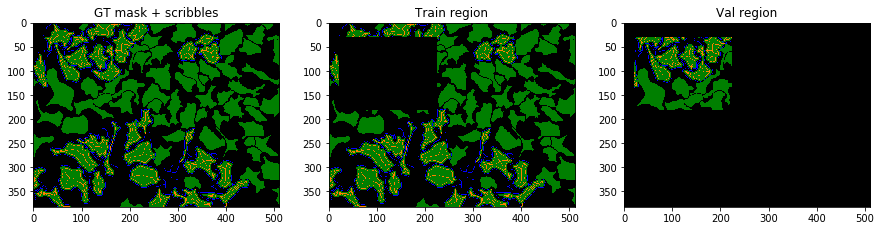

1 ['/data/natalia/intern20/PaperData/cellpose/', '003_img_cellpose_train_folder.npz', '003_img_cellpose_train_folder']
003_img_cellpose_train_folder_1task1class_10images_scribble_n300.npz
124997 244 69
92 244 0 204
check unique values scribbles : [0. 1.]
/data/natalia/intern20/PaperData/cellpose/003_img_cellpose_train_folder_1task1class_10images_scribble_n300.npz


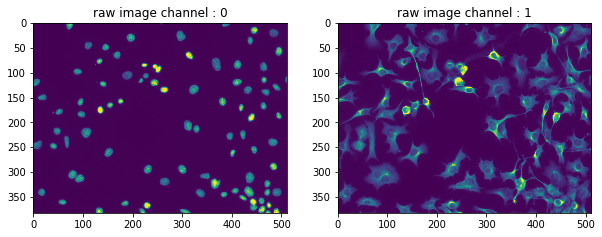

 task 0 ; classes : [0]
check sum of scribbles on same class (=1 or 0) : [0. 1.]


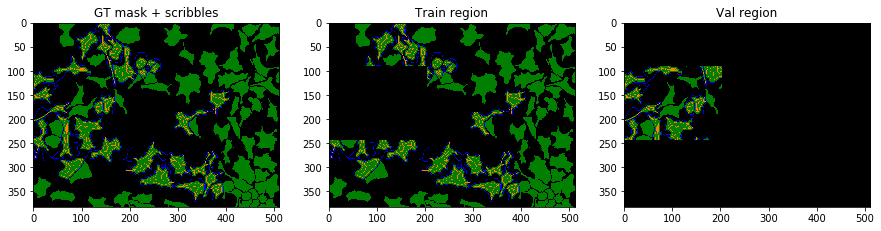

2 ['/data/natalia/intern20/PaperData/cellpose/', '006_img_cellpose_train_folder.npz', '006_img_cellpose_train_folder']
006_img_cellpose_train_folder_1task1class_10images_scribble_n300.npz
153681 300 81
148 300 0 204
check unique values scribbles : [0. 1.]
/data/natalia/intern20/PaperData/cellpose/006_img_cellpose_train_folder_1task1class_10images_scribble_n300.npz


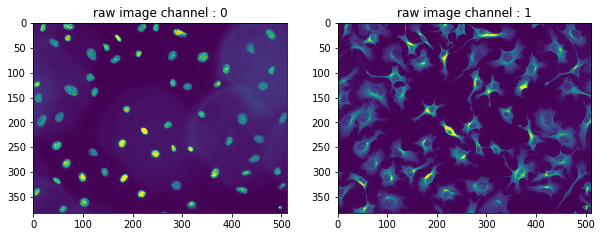

 task 0 ; classes : [0]
check sum of scribbles on same class (=1 or 0) : [0. 1.]


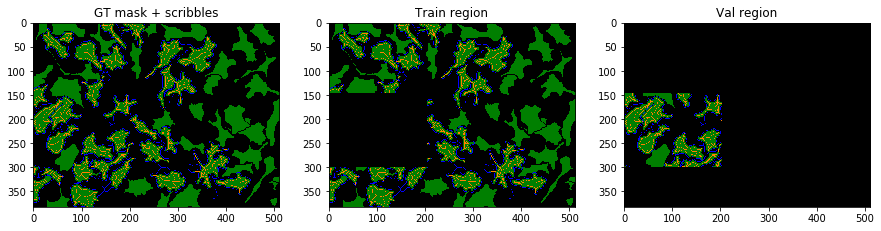

3 ['/data/natalia/intern20/PaperData/cellpose/', '009_img_cellpose_train_folder.npz', '009_img_cellpose_train_folder']
009_img_cellpose_train_folder_1task1class_10images_scribble_n300.npz
36705 71 353
0 152 149 353
check unique values scribbles : [0. 1.]
/data/natalia/intern20/PaperData/cellpose/009_img_cellpose_train_folder_1task1class_10images_scribble_n300.npz


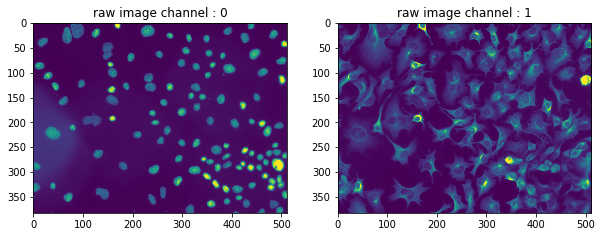

 task 0 ; classes : [0]
check sum of scribbles on same class (=1 or 0) : [0. 1.]


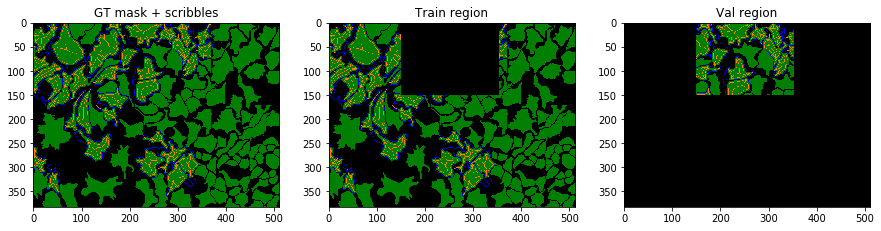

4 ['/data/natalia/intern20/PaperData/cellpose/', '019_img_cellpose_train_folder.npz', '019_img_cellpose_train_folder']
019_img_cellpose_train_folder_1task1class_10images_scribble_n300.npz
116226 227 2
75 227 0 204
check unique values scribbles : [0. 1.]
/data/natalia/intern20/PaperData/cellpose/019_img_cellpose_train_folder_1task1class_10images_scribble_n300.npz


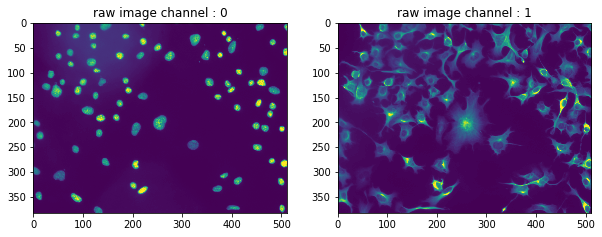

 task 0 ; classes : [0]
check sum of scribbles on same class (=1 or 0) : [0. 1.]


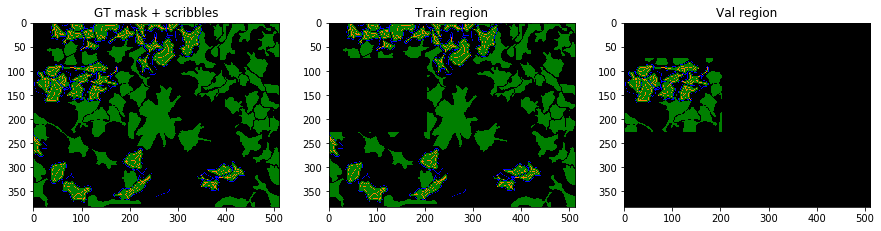

5 ['/data/natalia/intern20/PaperData/cellpose/', '035_img_cellpose_train_folder.npz', '035_img_cellpose_train_folder']
035_img_cellpose_train_folder_1task1class_10images_scribble_n300.npz
91716 179 68
27 179 0 204
check unique values scribbles : [0. 1.]
/data/natalia/intern20/PaperData/cellpose/035_img_cellpose_train_folder_1task1class_10images_scribble_n300.npz


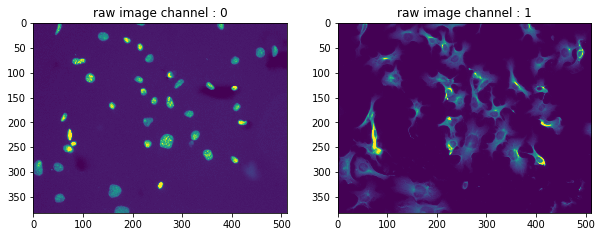

 task 0 ; classes : [0]
check sum of scribbles on same class (=1 or 0) : [0. 1.]


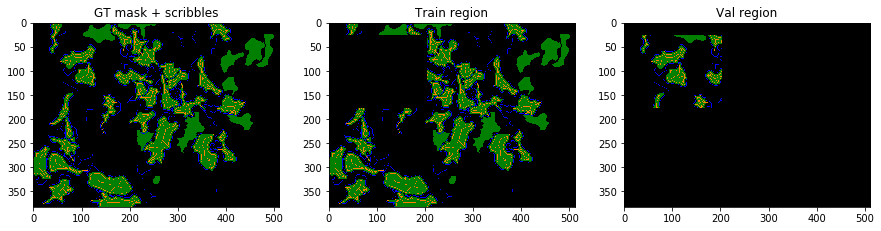

6 ['/data/natalia/intern20/PaperData/cellpose/', '039_img_cellpose_train_folder.npz', '039_img_cellpose_train_folder']
039_img_cellpose_train_folder_1task1class_10images_scribble_n300.npz
158566 309 358
157 309 154 358
check unique values scribbles : [0. 1.]
/data/natalia/intern20/PaperData/cellpose/039_img_cellpose_train_folder_1task1class_10images_scribble_n300.npz


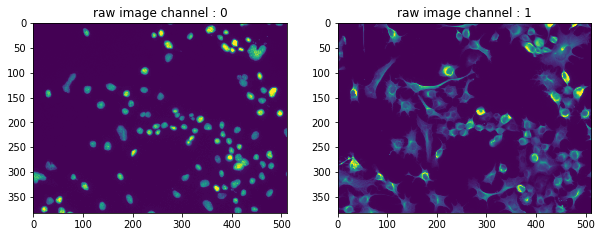

 task 0 ; classes : [0]
check sum of scribbles on same class (=1 or 0) : [0. 1.]


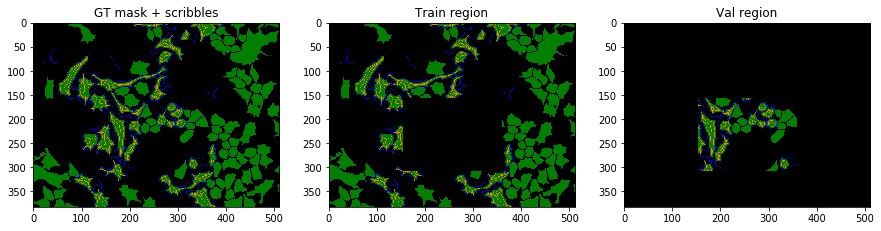

7 ['/data/natalia/intern20/PaperData/cellpose/', '096_img_cellpose_train_folder.npz', '096_img_cellpose_train_folder']
096_img_cellpose_train_folder_1task1class_10images_scribble_n300.npz
29813 74 213
0 160 53 213
check unique values scribbles : [0. 1.]
/data/natalia/intern20/PaperData/cellpose/096_img_cellpose_train_folder_1task1class_10images_scribble_n300.npz


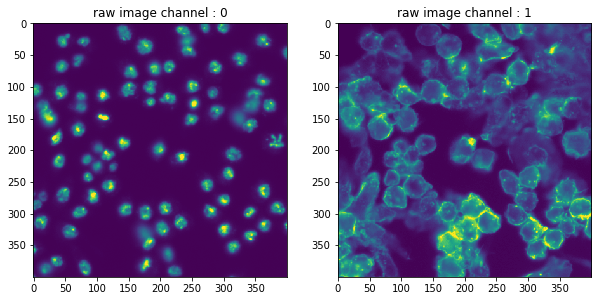

 task 0 ; classes : [0]
check sum of scribbles on same class (=1 or 0) : [0. 1.]


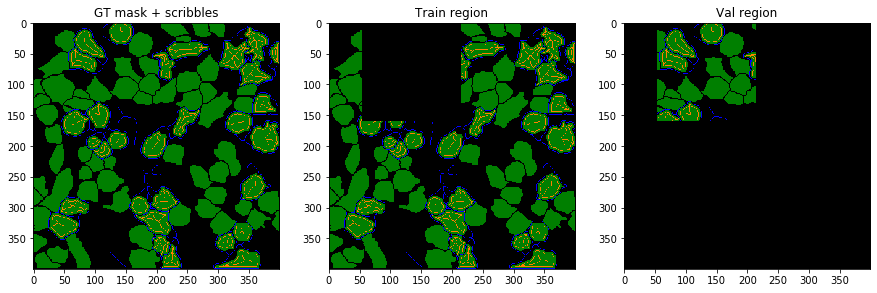

8 ['/data/natalia/intern20/PaperData/cellpose/', '099_img_cellpose_train_folder.npz', '099_img_cellpose_train_folder']
099_img_cellpose_train_folder_1task1class_10images_scribble_n300.npz
9073 22 273
0 160 113 273
check unique values scribbles : [0. 1.]
/data/natalia/intern20/PaperData/cellpose/099_img_cellpose_train_folder_1task1class_10images_scribble_n300.npz


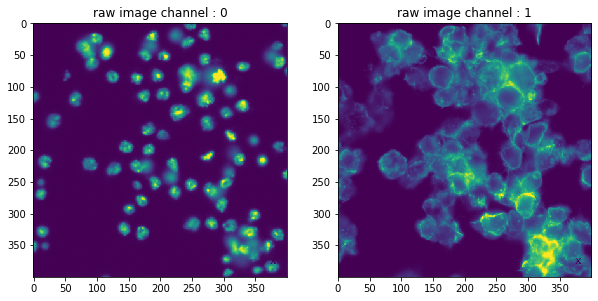

 task 0 ; classes : [0]
check sum of scribbles on same class (=1 or 0) : [0. 1.]


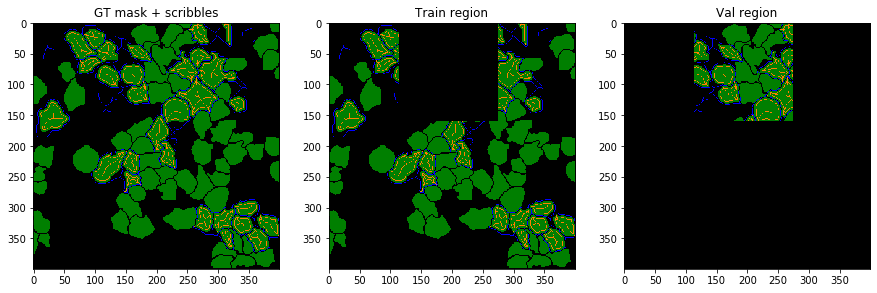

9 ['/data/natalia/intern20/PaperData/cellpose/', '102_img_cellpose_train_folder.npz', '102_img_cellpose_train_folder']
102_img_cellpose_train_folder_1task1class_10images_scribble_n300.npz
175530 390 30
210 390 0 180
check unique values scribbles : [0. 1.]
/data/natalia/intern20/PaperData/cellpose/102_img_cellpose_train_folder_1task1class_10images_scribble_n300.npz


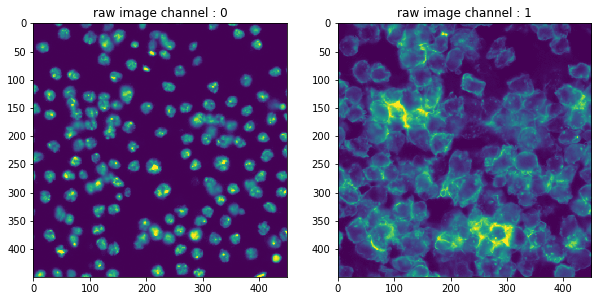

 task 0 ; classes : [0]
check sum of scribbles on same class (=1 or 0) : [0. 1.]


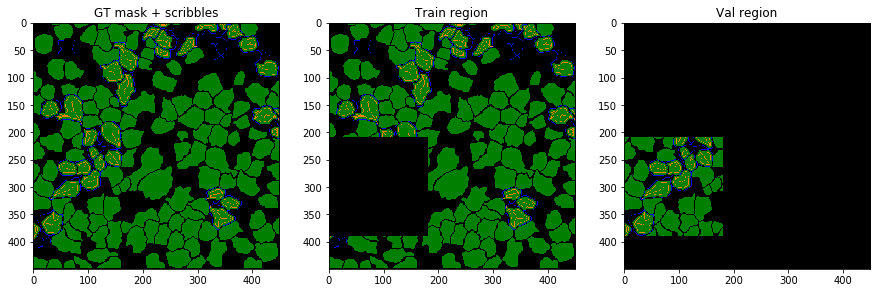

In [20]:
## Save scribbles
val_perc = 0.4
import copy
from csbdeep.utils import normalize
np.random.seed(9)
np.random.seed(44)
files_train_list = copy.deepcopy(files_train_list_aux)
for i in range(len(files_train_list)):
    
    image = X_train_list[i]
    label_gt = Y_gt_train_ch0_list[i][...,np.newaxis] 
    scribbles_ch = [Y_out_ch0_list[i]]
    
    
    ### save scribbles file name
    print(i,files_train_list[i])
    name_save = files_train_list[i][1].split('.')[0] + '_1task1class_10images_scribble_n'+str(int(nlabels_budget))+'.npz'
    print(name_save)
    files_train_list[i].extend([name_save])
    
    ### save number of labels with scribbles per channel
    for ch in np.arange(len(scribbles_ch)):
        label_ch = label_gt[...,ch]
        s_ch = scribbles_ch[ch]

        #nlabels with scribbles
        label_wscribble = np.unique(label_ch[s_ch[...,0]>0].flatten())
        nscribbles = label_wscribble.shape[0]
        nlabels = np.unique(label_ch[label_ch>0]).shape[0]
        pixels_scribbled_TP = np.round(100*np.sum(s_ch[...,0]>0)/ (np.sum(label_ch>0)),2)
        pixels_scribbled_TN = np.round(100*np.sum(s_ch[...,1]>0)/ (np.sum(label_ch==0)),2)
        files_train_list[i].extend([int(nlabels),int(nscribbles),
                                    label_wscribble,pixels_scribbled_TP,pixels_scribbled_TN])
    
    ### Define classification tasks and their scribbles
    tasks_classes = {'0':[0]}
    
    scribble = None
    for tasks in tasks_classes.keys():
        start_task = True
        for ch in tasks_classes[tasks]:
            
            s_ch = scribbles_ch[ch]
            
            label_ch = np.array(label_gt)
            label_ch[...,ch] = 0
            label_ch = label_ch[...,tasks_classes[tasks]]
            label_ch[label_ch>0] = 1
            label_ch = np.sum(label_ch,-1)
            
            if start_task:
                background = np.array(s_ch[...,1])*(1-label_ch) + 0 #make sure no foreground is set as background
                scribble_task = np.array(s_ch[...,0])[...,np.newaxis] + 0
                start_task = False
            else:
                background += np.array(s_ch[...,1])*(1-label_ch) #make sure no foreground is set as background
                scribble_task = np.concatenate([scribble_task, np.array(s_ch[...,0])[...,np.newaxis]],axis = -1)
                
        scribble_task = np.concatenate([scribble_task,background[...,np.newaxis]],axis = -1)
        scribble_task[scribble_task>0] = 1
        
        if scribble is None:
            scribble = np.array(scribble_task)
        else:
            scribble = np.concatenate([scribble,scribble_task],axis = -1)
                
    
    ### validation sample region mask ###
    region_val_size = [int(image.shape[0] * val_perc/2),int(image.shape[1] * val_perc/2)] #validation region
    mask_scribbles = np.sum(scribble,axis = -1)
    mask_scribbles[mask_scribbles>0] = 1
    from scipy import ndimage
    mask_scribbles = ndimage.convolve(mask_scribbles, np.ones([5,5]), mode='constant', cval=0.0)
    #remove borders
#     mask_scribbles[-region_val_size[0]:,:] = 0
#     mask_scribbles[:,-region_val_size[1]:] = 0
#     mask_scribbles[0:region_val_size[0],:] = 0
#     mask_scribbles[:,0:region_val_size[1]] = 0
    val_center = np.random.multinomial(1, mask_scribbles.flatten()/np.sum(mask_scribbles.flatten()), size=1).flatten()
    ix_center = np.argmax(val_center)
    ix_row = int(np.floor(ix_center/image.shape[1]))
    ix_col = int(ix_center - ix_row * image.shape[1])
    print(ix_center,ix_row,ix_col)
    
    row_low = np.maximum(ix_row-region_val_size[0],0)
    row_high = np.minimum(row_low+region_val_size[0],image.shape[0])
    row_low = np.maximum(row_high - 2*region_val_size[0],0)
    row_high = np.minimum(row_low+ 2*region_val_size[0],image.shape[0])
    
    col_low = np.maximum(ix_col-region_val_size[1],0)
    col_high = np.minimum(col_low+region_val_size[1],image.shape[1])
    col_low = np.maximum(col_high - 2*region_val_size[1],0)
    col_high = np.minimum(col_low+2*region_val_size[1],image.shape[1])
    print(row_low,row_high,col_low,col_high)
    
    validation_mask = np.zeros([image.shape[0],image.shape[1]])
    validation_mask[row_low:row_high,
                    col_low:col_high] = 1
#     validation_mask[ix_row-region_val_size[0]:ix_row+region_val_size[0],
#                     ix_col-region_val_size[1]:ix_col+region_val_size[1]] = 1
    
    ## saving
    print('check unique values scribbles :',np.unique(scribble))
    print(files_train_list[i][0]+name_save)
    np.savez(files_train_list[i][0]+name_save,scribble=scribble,val_mask = validation_mask)
    
    ############################################# Plots #############################################
    #plot input channels
    plt.figure(figsize=(10,5))
    ix = 0
    for ch in range(image.shape[-1]):
        image_plot = normalize(image[...,ch],pmin=1,pmax=99.8,clip = True)
        plt.subplot(1,image.shape[-1],ix + 1)
        ix += 1
        plt.title('raw image channel : '+ str(ch))
        plt.imshow(image_plot)
    plt.show()
    
    itask = 0
    for tasks in tasks_classes.keys():
        classes_lists = tasks_classes[tasks]
        print(' task '+ str(tasks) + ' ; classes :',classes_lists)
        
        label_ch = np.array(label_gt[...,classes_lists])
        label_ch[label_ch>0] = 1
        label_ch = np.sum(label_ch*(np.arange(len(classes_lists))+1)[np.newaxis,np.newaxis,:],-1)
        print('check sum of scribbles on same class (=1 or 0) :',
              np.unique(np.sum(scribble[...,itask:itask+len(classes_lists)+1],-1)))
        
        aux = np.zeros([image_plot.shape[0],image_plot.shape[1],3])
        aux[...,1] = label_ch*0.5/len(classes_lists)
        aux[...,0] = np.sum(scribble[...,itask:itask+len(classes_lists)],-1)
        aux[...,2] = scribble[...,itask+len(classes_lists)]
        itask += len(classes_lists)+1
        
        plt.figure(figsize=(15,5))
        plt.subplot(1,3,1)
        plt.title('GT mask + scribbles')
        plt.imshow(aux)

        plt.subplot(1,3,2)
        plt.title('Train region')
        plt.imshow(aux*(1-validation_mask[...,np.newaxis]))

        plt.subplot(1,3,3)
        plt.title('Val region')
        plt.imshow(aux*validation_mask[...,np.newaxis])
        plt.show()

In [21]:
columns = ['input_dir','input_file','prefix','scribble_file']
for ch in np.arange(1):
    for col in ['total_labels','scribble_labels',
                'label_with_scribble','perc_pixels_scribbles_TP','perc_pixels_scribbles_TN']:
        columns.append(col+'_class'+str(ch))

pd_scribbles = pd.DataFrame(data=files_train_list,columns=columns)

for task in tasks_classes.keys():
    pd_scribbles['gt_index_task'+task] = [tasks_classes[task] for _ in range(len(pd_scribbles))]

print('Saving in: ')
namefile = data_dir+'files_1task1class_10images_scribble_train_'+str(int(nlabels_budget))+'.csv'
print(namefile)
pd_scribbles.to_csv(namefile,index=None)

pd_scribbles

Saving in: 
/data/natalia/intern20/PaperData/cellpose/files_1task1class_10images_scribble_train_300.csv


,input_dir,input_file,prefix,scribble_file,total_labels_class0,scribble_labels_class0,label_with_scribble_class0,perc_pixels_scribbles_TP_class0,perc_pixels_scribbles_TN_class0,gt_index_task0
0,/data/natalia/intern20/PaperData/cellpose/,000_img_cellpose_train_folder.npz,000_img_cellpose_train_folder,000_img_cellpose_train_folder_1task1class_10im...,90,30,"[1, 4, 5, 7, 9, 10, 12, 13, 17, 18, 19, 20, 25...",6.81,5.04,[0]
1,/data/natalia/intern20/PaperData/cellpose/,003_img_cellpose_train_folder.npz,003_img_cellpose_train_folder,003_img_cellpose_train_folder_1task1class_10im...,94,29,"[1, 2, 7, 8, 12, 13, 17, 18, 19, 20, 21, 22, 2...",7.46,3.77,[0]
2,/data/natalia/intern20/PaperData/cellpose/,006_img_cellpose_train_folder.npz,006_img_cellpose_train_folder,006_img_cellpose_train_folder_1task1class_10im...,65,31,"[2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 14, 15, 17, ...",9.64,4.82,[0]
3,/data/natalia/intern20/PaperData/cellpose/,009_img_cellpose_train_folder.npz,009_img_cellpose_train_folder,009_img_cellpose_train_folder_1task1class_10im...,121,30,"[1, 2, 3, 4, 8, 9, 10, 11, 12, 13, 16, 17, 18,...",6.25,5.98,[0]
4,/data/natalia/intern20/PaperData/cellpose/,019_img_cellpose_train_folder.npz,019_img_cellpose_train_folder,019_img_cellpose_train_folder_1task1class_10im...,90,31,"[3, 6, 7, 8, 10, 11, 12, 13, 14, 18, 19, 22, 2...",5.94,3.19,[0]
5,/data/natalia/intern20/PaperData/cellpose/,035_img_cellpose_train_folder.npz,035_img_cellpose_train_folder,035_img_cellpose_train_folder_1task1class_10im...,40,30,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15...",13.21,4.01,[0]
6,/data/natalia/intern20/PaperData/cellpose/,039_img_cellpose_train_folder.npz,039_img_cellpose_train_folder,039_img_cellpose_train_folder_1task1class_10im...,111,30,"[8, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 23...",7.17,3.11,[0]
7,/data/natalia/intern20/PaperData/cellpose/,096_img_cellpose_train_folder.npz,096_img_cellpose_train_folder,096_img_cellpose_train_folder_1task1class_10im...,88,30,"[9, 11, 12, 14, 15, 21, 22, 23, 27, 28, 33, 35...",5.36,4.74,[0]
8,/data/natalia/intern20/PaperData/cellpose/,099_img_cellpose_train_folder.npz,099_img_cellpose_train_folder,099_img_cellpose_train_folder_1task1class_10im...,86,29,"[6, 8, 10, 11, 12, 13, 14, 18, 19, 20, 21, 30,...",5.83,3.67,[0]
9,/data/natalia/intern20/PaperData/cellpose/,102_img_cellpose_train_folder.npz,102_img_cellpose_train_folder,102_img_cellpose_train_folder_1task1class_10im...,154,32,"[5, 6, 9, 13, 14, 23, 25, 28, 31, 36, 39, 44, ...",2.84,3.87,[0]
